In [22]:
import json
import scipy
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

In [6]:
np.random.seed(12132707)

In [200]:
df = pd.concat([pd.read_csv(
    "./Kaggle-Data-Science-ML-Survey-Analysis/data/processed/ProcessedSurveyData_%d.csv" % i) 
                       for i in range(2020,2023)])
df = df[df['Country']=='United States of America']
df = df.dropna(subset=['AnnualComp(USD)'])
df.head(3)

,Unnamed: 0,Unnamed: 0.1,Duration (in seconds),Age,Gender,Country,IsStudent,MOOCPlatforms_Coursera,MOOCPlatforms_edX,MOOCPlatforms_Kaggle Learn Courses,...,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER
1,2,NaN,289287,30-34,Man,United States of America,No,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,507,30-34,Man,United States of America,No,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,12,NaN,742,35-39,Man,United States of America,No,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [201]:
len(df)

4763

## High Level Plan
1. Preprocessing for Regression, EDA
2. Feature selection
3. Models: Linear Regression, Lasso, Ridge, RF regression, XGBoost
4. Investigation: Plot of preds vs actual; GLMs: NB regression.
5. Modeling results: Table of diff regression models with metrics, SD on k-fold CV
6. Interpretability: Feature importance scores; Explain Preds using Shap

# 1. Preprocessing

## 1.1 Salary: Categorical -> Numeric 

### Problem:
The salaries are reported on a categorical scale, and have unequal bin widths. Exp: 1-2k, 2.5-5k, 125k-150k. These need to be converted to a numerical scale.

### Possible solutions
1. Assume a **uniform distribution** over the lower and upper salary limit. For exp, for salary range 1-2k, sample a salary uniformly between 1-2k.
2. Sample a no. s between 0 and 1 from a **Beta distribution** centered at 0.5. Sampled salary = LL + s (UL - LL).
3. Get the distribution of salaries from a tech salaries dataset. Normalize the densities in a constrained range and sample from the constrained distribution using **Inverse Transform sampling** (for exp, normalize densities bw 125k-150k to integrate to 1, and sample from this distribution).

In [35]:
sal = pd.read_csv("./salaries.csv")
sal[sal['company_location'] == 'US']
sal.head(3)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2022,SE,FT,Data Analyst,177000,USD,177000,US,0,US,M
1,2022,SE,FT,Data Analyst,131000,USD,131000,US,0,US,M
2,2022,SE,FT,Applied Scientist,205000,USD,205000,US,100,US,M


In [36]:
sal['work_year'].value_counts()

2022    1163
2021     224
2020      75
Name: work_year, dtype: int64

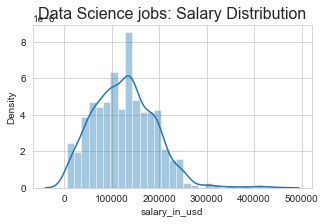

In [175]:
plt.figure(figsize=(5,3))
sns.distplot(sal['salary_in_usd'])
plt.title("Data Science jobs: Salary Distribution", size=16)
plt.show()

In [84]:
def compute_cdf(salaries): # Empirical CDF
    cdf = np.cumsum(salaries)
    cdf = (cdf - cdf.min())/(cdf.max() - cdf.min()) # Normalize from 0 to 1
    return cdf

In [129]:
# Inverse Transform Sampling
salaries = np.sort(sal['salary_in_usd'])
cdf = compute_cdf(salaries) # Empirical CDF
inverse_cdf = scipy.interpolate.interp1d(cdf, salaries) # Interpolate values of salary for all vals bw 0 & 1
inverse_cdf(0.1) # Inverse transform sampling to sample from the required distribution

array(80000.)

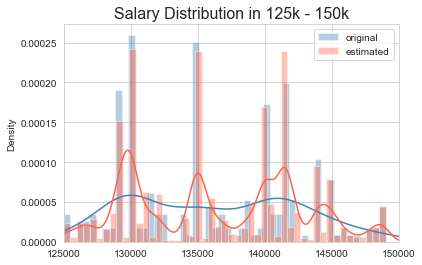

In [119]:
# Suppose we want samples for salary category 125k-150k
sal_1 = salaries[(salaries >= 125000) & (salaries < 150000)]
sal_1 = np.sort(sal_1)
cdf = compute_cdf(sal_1)
inverse_cdf = scipy.interpolate.interp1d(cdf, sal_1)

# Inverse Transform Sampling
u = np.random.random(size=10**5) # Uniform samples

plt.figure(figsize=(6,4))
sns.distplot(sal_1, color='steelblue', label='original', bins=50)
sns.distplot(inverse_cdf(u), color='tomato', label='estimated')
plt.xlim(125000, 150000)
plt.title("Salary Distribution in 125k - 150k", size=16)
plt.legend()
plt.show()

In [128]:
salary_grps = [
        (1000,1999),
        (2000,2999),
        (3000,3999),
        (4000,4999),
        (5000,7499),
        (7500,9999),

        (10000,14999),
        (15000,19999),
        (20000,24999),
        (25000,29999),
        (30000,39999),
        (40000,49999),
        (50000,59999),
        (60000,69999),
        (70000,79999),
        (80000,89999),
        (90000,99999),

        (100000,124999),
        (125000,149999),
        (150000,199999),
        (200000,249999),
        (250000,299999),
        (300000,499999),
        (500000,999999),
        (1000000,1000000)
]

In [237]:
inverse_cdfs = {}
salaries = np.sort(sal['salary_in_usd'])

for ll, ul in salary_grps:
    sals = salaries[(salaries >= ll) & (salaries < ul)]
    if len(sals) < 20:
        #print(ll, len(sals))
        continue
    sals = np.insert(sals, 0, ll)
    sals = np.insert(sals, len(sals), ul)
    sals = np.sort(sals)
    cdf = compute_cdf(sals)
    inverse_cdf = scipy.interpolate.interp1d(cdf, sals)
    inverse_cdfs[ll] = inverse_cdf

In [239]:
def sample_salary(sal_categ, salary_grps, inverse_cdfs):
    if sal_categ == "> $500,000":
        return np.random.uniform(500000, 1000000)
    
    elif sal_categ == ">$1,000,000":
        return np.random.uniform(1000000, 1500000)
    
    else:
        sal_categ = sal_categ.replace(',', '').replace('$', '')
        sal_categ = sal_categ.strip()

        lims = sal_categ.split('-')
        ll = int(lims[0])
        ul = int(lims[1])

        if(ll in inverse_cdfs):
            u = np.random.uniform(0,1) # Uniform sample bw 0, 1
            return inverse_cdfs[ll](u)

            return np.random.uniform(ll, ul) # If insufficient no. of samples, assume uniform distribution

In [234]:
df['salary'] = df['AnnualComp(USD)'].apply(lambda sal: sample_salary(sal, salary_grps, inverse_cdfs))

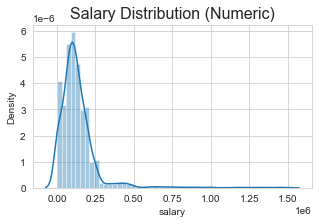

In [241]:
plt.figure(figsize=(5,3))
sns.distplot(df['salary'])
plt.title("Salary Distribution (Numeric)", size=16)
plt.show()